In [62]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [63]:
!pip install tensorflow==2.5.1 tensorflow opencv-python matplotlib

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [12]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [67]:
POS_PATH

'data\\positive'

In [68]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz


In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate unique image names
import uuid

In [70]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\c3d801d2-b219-11ee-88cb-b07b25670f1a.jpg'

In [71]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(10) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(10) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

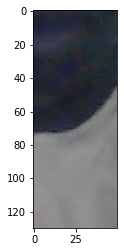

In [72]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [73]:
cv2.VideoCapture()

< cv2.VideoCapture 00000244B4F7D5D0>

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [18]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [76]:
dir_test = anchor.as_numpy_iterator()

In [77]:
print(dir_test.next())

b'data\\anchor\\4f588174-acd9-11ee-af67-b07b25670f1a.jpg'


In [78]:
img = preprocess('data\\anchor\\25933c4f-acd9-11ee-b3f1-b07b25670f1a.jpg')

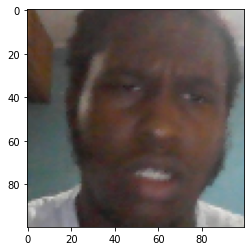

In [79]:
plt.imshow(img)

In [80]:
#dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [85]:
samples = data.as_numpy_iterator()

In [86]:
exampple = samples.next()

In [87]:
exampple


(b'data\\anchor\\098965c7-acd9-11ee-8bdc-b07b25670f1a.jpg',
 b'data\\positive\\12844ff5-acd9-11ee-af66-b07b25670f1a.jpg',
 1.0)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [89]:
res = preprocess_twin(*exampple)

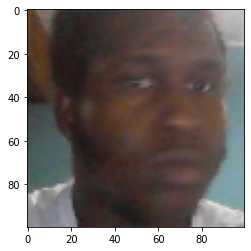

In [90]:
plt.imshow(res[0])

In [19]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [76]:
samples = data.as_numpy_iterator()

In [93]:
samp = samples.next()

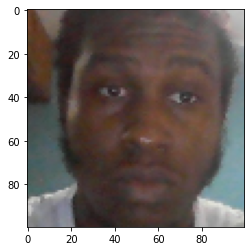

In [94]:
plt.imshow(samp[0])

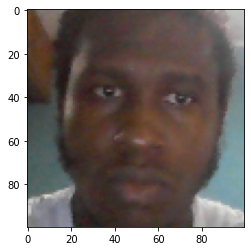

In [95]:
plt.imshow(samp[1])

In [96]:
samp[2]


1.0

In [98]:
# Training partition
train_data = data.take(round(len(data)*.7)) #takes the first number of images
train_data = train_data.batch(16) #passes data in batches of 16 images
train_data = train_data.prefetch(8) #starts pre processing the next set of images to prevent bottlenecking

In [20]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) #skipps the first batches (skips the trainig partition images)
test_data = test_data.take(round(len(data)*.3)) #takes a set of images
test_data = test_data.batch(16) #passes data in batches of 16 images
test_data = test_data.prefetch(8) #starts pre processing the next set of images to prevent bottlenecking

In [99]:
#Building Embedding Layer

inp = Input(shape=(100,100,3), name='input_image')

In [100]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [101]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [102]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [32]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
embedding = make_embedding()

In [105]:
embedding.summary()


Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 128)         0 

In [27]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [108]:
#l1(anchor_embedding, validation_embedding)

In [25]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))


    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [34]:
siamese_model = make_siamese_model()

In [111]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [82]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [53]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [86]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [87]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [88]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [118]:
EPOCHS = 50

In [119]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 898s 33s/step
0.517781 0.34313726 1.0

 Epoch 2/50
27/27 [==============================] - 960s 36s/step
0.14895229 0.9609756 0.9949495

 Epoch 3/50
27/27 [==============================] - 932s 34s/step
0.00027579014 0.9953052 1.0

 Epoch 4/50
27/27 [==============================] - 926s 34s/step
0.7327655 0.95852536 0.9811321

 Epoch 5/50
27/27 [==============================] - 940s 35s/step
0.1343896 0.9858491 0.99523807

 Epoch 6/50
27/27 [==============================] - 925s 34s/step
0.0004427529 0.98122066 1.0

 Epoch 7/50
27/27 [==============================] - 955s 35s/step
0.009669265 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 934s 35s/step
0.0061130226 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 930s 34s/step
0.0704329 1.0 1.0

 

In [2]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [22]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [42]:
y_hat = siamese_model.predict([test_input, test_val])

In [36]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
y_true


array([1., 1., 0., 1.], dtype=float32)

In [44]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [45]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.75

In [46]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 0.51111114


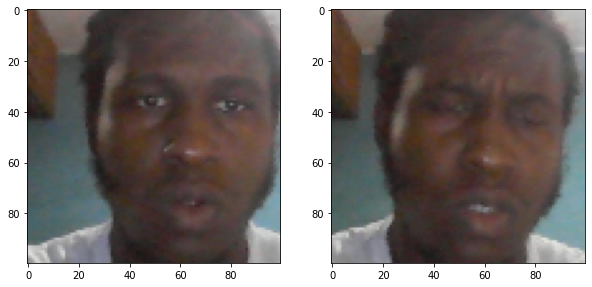

In [49]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [50]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [66]:
import tensorflow as tf

# Define the checkpoint directory
check_dir = './training_checkpoints/checkpoint'

# Get the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(tf.keras.Model(Model))

# Restore the model weights from the checkpoint file
checkpoint.restore(latest_checkpoint)

if checkpoint == status


In [63]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [107]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./training_checkpoints\ckpt-5


In [108]:
EPOCH = 10
train(train_data,EPOCH)



 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 869s 32s/step
0.6553836 0.5285714 0.47033897

 Epoch 2/10
27/27 [==============================] - 745s 27s/step
0.6954344 1.0 0.51666665

 Epoch 3/10
27/27 [==============================] - 714s 26s/step
0.6931875 0.36966825 0.47560975

 Epoch 4/10
27/27 [==============================] - 713s 26s/step
0.69431186 1.0 0.50238097

 Epoch 5/10
27/27 [==============================] - 709s 26s/step
0.7005899 0.16346154 0.5

 Epoch 6/10
27/27 [==============================] - 715s 26s/step
0.71575487 0.16019417 0.4852941

 Epoch 7/10
27/27 [==============================] - 709s 26s/step
0.6752042 0.71028036 0.5

 Epoch 8/10
27/27 [==============================] - 713s 26s/step
0.7238195 0.5410628 0.5

 Epoch 9/10
27/27 [==============================] - 710s 26s/step
0.6935526 0.22

In [109]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [110]:
L1Dist


__main__.L1Dist

In [111]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [112]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.43777236],
       [0.43777236],
       [0.43777236],
       [0.43777236]], dtype=float32)

In [113]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [117]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [121]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.4, 0.4)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
